# Fine-tuning BERT on long texts

## Hierarchical Method

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install transformers==2.10.0

In [3]:
import sys
sys.path.append("./drive/MyDrive/ML-Project/RoBERT")

%matplotlib inline
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
import transformers
from transformers import RobertaTokenizer, BertTokenizer, RobertaModel, BertModel, AdamW# get_linear_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup
import time

from utils import *
from Custom_Dataset_Class import NewsGroupDataset
from Bert_Classification import Bert_Classification_Model
from RoBERT import RoBERT_Model

from BERT_Hierarchical import BERT_Hierarchical_Model_20NG
import warnings
warnings.filterwarnings("ignore")

In [4]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Mean Pooling

In [ ]:
TRAIN_BATCH_SIZE=1
EPOCH=3
validation_split = .2
shuffle_dataset = True
random_seed= 42
MIN_LEN=249
MAX_LEN = 100000
CHUNK_LEN=200
OVERLAP_LEN=50
#MAX_LEN=10000000
#MAX_SIZE_DATASET=1000

print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

dataset=NewsGroupDataset(
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    #max_size_dataset=MAX_SIZE_DATASET,
    overlap_len=OVERLAP_LEN)


#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler,
    collate_fn=my_collate1)

valid_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler,
    collate_fn=my_collate1)


device=torch.device("cuda")
lr=3e-5#1e-3
num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

pooling_method="mean"
model_hierarchical=BERT_Hierarchical_Model_20NG(pooling_method=pooling_method).to(device)
optimizer=AdamW(model_hierarchical.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\nEpoch {epoch+1}/{EPOCH}\n")
    batches_losses_tmp=rnn_train_loop_fun1(train_data_loader, model_hierarchical, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"Average loss : {epoch_loss:.2f} - {(time.time()-t0)//60}min ({time.time()-t0:.2f}sec\n")
    t1=time.time()
    output, target, val_losses_tmp=rnn_eval_loop_fun1(valid_data_loader, model_hierarchical, device)
    print(f"Average Validation loss: {np.mean(val_losses_tmp):.2f} - {time.time()-t1:.2f}sec\n")   
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print(f"The Hierarchical {pooling_method} pooling model has been saved in the drive")
    torch.save(model_hierarchical, f"./drive/MyDrive/ML-Project/RoBERT/20_newsgroup/model_hierarchical/{pooling_method}_pooling/model_{pooling_method}_pooling_epoch{epoch+1}.pt")    

Loading BERT tokenizer...



Data Cleaning




Epoch 1/3

0/2201 (0.00%) - 0.44sec - loss = 3.0165
250/2201 (11.36%) - 84.16sec - loss = 1.1202
500/2201 (22.72%) - 67.86sec - loss = 1.3912
750/2201 (34.08%) - 61.24sec - loss = 0.8819
1000/2201 (45.43%) - 60.92sec - loss = 0.3557
1250/2201 (56.79%) - 60.82sec - loss = 1.6755
1500/2201 (68.15%) - 59.86sec - loss = 0.6434
1750/2201 (79.51%) - 64.13sec - loss = 0.5711
2000/2201 (90.87%) - 65.59sec - loss = 0.9819
Average loss : 1.27 - 9.0min (573.66sec

Average Validation loss: 0.74 - 49.30sec

{'accuracy': 0.7606679035250464, 'nb exemple': 539, 'true_prediction': 410, 'false_prediction': 129}
The Hierarchical mean pooling model has been saved in the drive

Epoch 2/3

0/2201 (0.00%) - 0.67sec - loss = 0.0602
250/2201 (11.36%) - 71.05sec - loss = 0.9758
500/2201 (22.72%) - 64.55sec - loss = 0.7438
750/2201 (34.08%) - 116.39sec - loss = 0.8073
1000/2201 (45.43%) - 61.80sec - loss = 0.3241
1250/2201 (56.79%) - 56.38sec - loss = 0.3586
1500/2201 (68.15%) - 60.27sec - loss = 0.9990
1750/2

### Max Pooling

In [5]:
TRAIN_BATCH_SIZE=1
EPOCH=3
validation_split = .2
shuffle_dataset = True
random_seed= 42
MIN_LEN=249
MAX_LEN = 100000
CHUNK_LEN=200
OVERLAP_LEN=50
#MAX_LEN=10000000
#MAX_SIZE_DATASET=1000

print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

dataset=NewsGroupDataset(
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    #max_size_dataset=MAX_SIZE_DATASET,
    overlap_len=OVERLAP_LEN)


#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler,
    collate_fn=my_collate1)

valid_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler,
    collate_fn=my_collate1)


device=torch.device("cuda")
lr=3e-5#1e-3
num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

pooling_method="max"
model_hierarchical=BERT_Hierarchical_Model_20NG(pooling_method=pooling_method).to(device)
optimizer=AdamW(model_hierarchical.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\nEpoch {epoch+1}/{EPOCH}\n")
    batches_losses_tmp=rnn_train_loop_fun1(train_data_loader, model_hierarchical, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"Average loss : {epoch_loss:.2f} - {(time.time()-t0)//60}min ({time.time()-t0:.2f}sec\n")
    t1=time.time()
    output, target, val_losses_tmp=rnn_eval_loop_fun1(valid_data_loader, model_hierarchical, device)
    print(f"Average Validation loss: {np.mean(val_losses_tmp):.2f} - {time.time()-t1:.2f}sec\n")    
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print(f"The Hierarchical {pooling_method} pooling model has been saved in the drive")
    torch.save(model_hierarchical, f"./drive/MyDrive/ML-Project/RoBERT/20_newsgroup/model_hierarchical/{pooling_method}_pooling/model_{pooling_method}_pooling_epoch{epoch+1}.pt")

Loading BERT tokenizer...



Data Cleaning




Epoch 1/3

0/2201 (0.00%) - 0.49sec - loss = 2.7093
250/2201 (11.36%) - 60.65sec - loss = 2.0579
500/2201 (22.72%) - 102.59sec - loss = 1.2724
750/2201 (34.08%) - 65.92sec - loss = 0.9143
1000/2201 (45.43%) - 60.76sec - loss = 0.9906
1250/2201 (56.79%) - 60.41sec - loss = 1.0339
1500/2201 (68.15%) - 63.85sec - loss = 0.4431
1750/2201 (79.51%) - 58.08sec - loss = 0.4666
2000/2201 (90.87%) - 63.04sec - loss = 1.5556
Average loss : 1.35 - 9.0min (584.45sec

Average Validation loss: 0.85 - 51.23sec

{'accuracy': 0.7286245353159851, 'nb exemple': 538, 'true_prediction': 392, 'false_prediction': 146}
The Hierarchical max pooling model has been saved in the drive

Epoch 2/3

0/2201 (0.00%) - 0.27sec - loss = nan
250/2201 (11.36%) - 65.53sec - loss = 0.9151
500/2201 (22.72%) - 98.89sec - loss = 0.5797
750/2201 (34.08%) - 62.34sec - loss = 0.9201
1000/2201 (45.43%) - 62.00sec - loss = 0.4760
1250/2201 (56.79%) - 63.11sec - loss = 0.4275
1500/2201 (68.15%) - 61.34sec - loss = 0.5747
1750/2201 

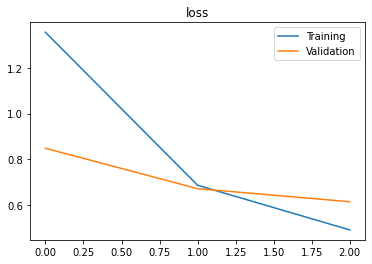

In [6]:
pd.DataFrame(np.array([[np.mean(x) for x in batches_losses], [np.mean(x) for x in val_losses]]).T, columns=['Training', 'Validation']).plot(title="loss")

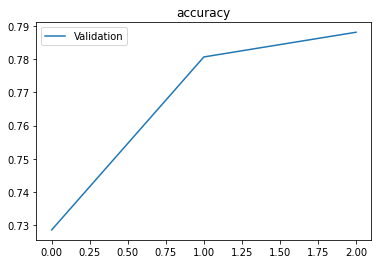

In [7]:
pd.DataFrame(np.array(val_acc).T, columns=['Validation']).plot(title="accuracy")